<a href="https://colab.research.google.com/github/YoshifumiMiyagi/VinDr-PCXR/blob/main/VinDr_PCXR_keras_vol_2(from_npy_load).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
# import zipfile
# with zipfile.ZipFile("/content/drive/MyDrive/download.zip", 'r') as zip_ref:
#     zip_ref.extractall("/content")

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import os
import cv2
import tensorflow as tf
from keras import backend as K
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.models import load_model
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv2D, MaxPool2D, Flatten,Input
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.utils import to_categorical

In [55]:
df = np.load("/content/drive/MyDrive/VinDR_PCXR_224_224_label_case2157_control5143.npy")

In [56]:
df.shape

(7300, 50177)

In [57]:
X, y = df[:,:-1], df[:,-1]
pd.Series(y).value_counts()

,count
0.0,5143
1.0,2157


In [58]:
Case = X[y==1]
Control = X[y==0]

In [59]:
size = 224

# Case

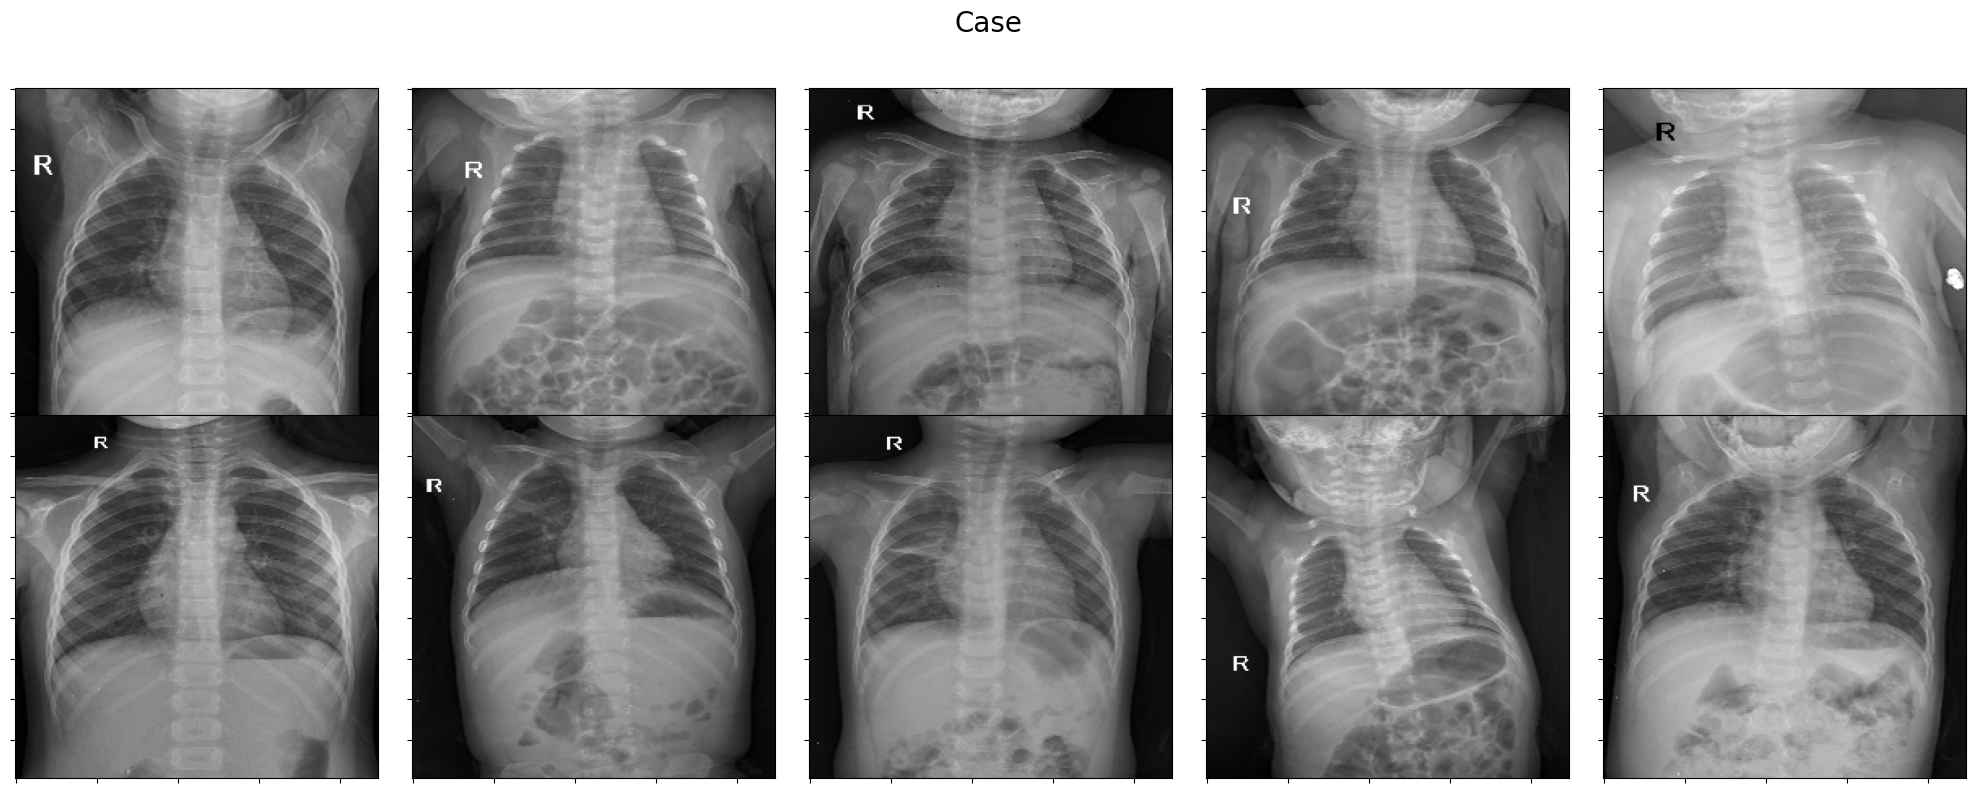

In [60]:
f = plt.figure(figsize=(20,8))
f.subplots_adjust(top=1)
for i in range(10):
    sp = f.add_subplot(2,5,i+1)
    X2 = Case.reshape(-1,size, size)
    X2 = img_to_array(X2[i])
    X2 = 255-X2
    X2 = array_to_img(X2)
    plt.tick_params(labelbottom=False,
                labelleft=False,
                labelright=False,
                labeltop=False)
    plt.imshow(X2)
    plt.gray()
plt.tight_layout(rect=[0,0,1,0.9])
plt.suptitle('Case',fontsize=20)
plt.show()

# Control

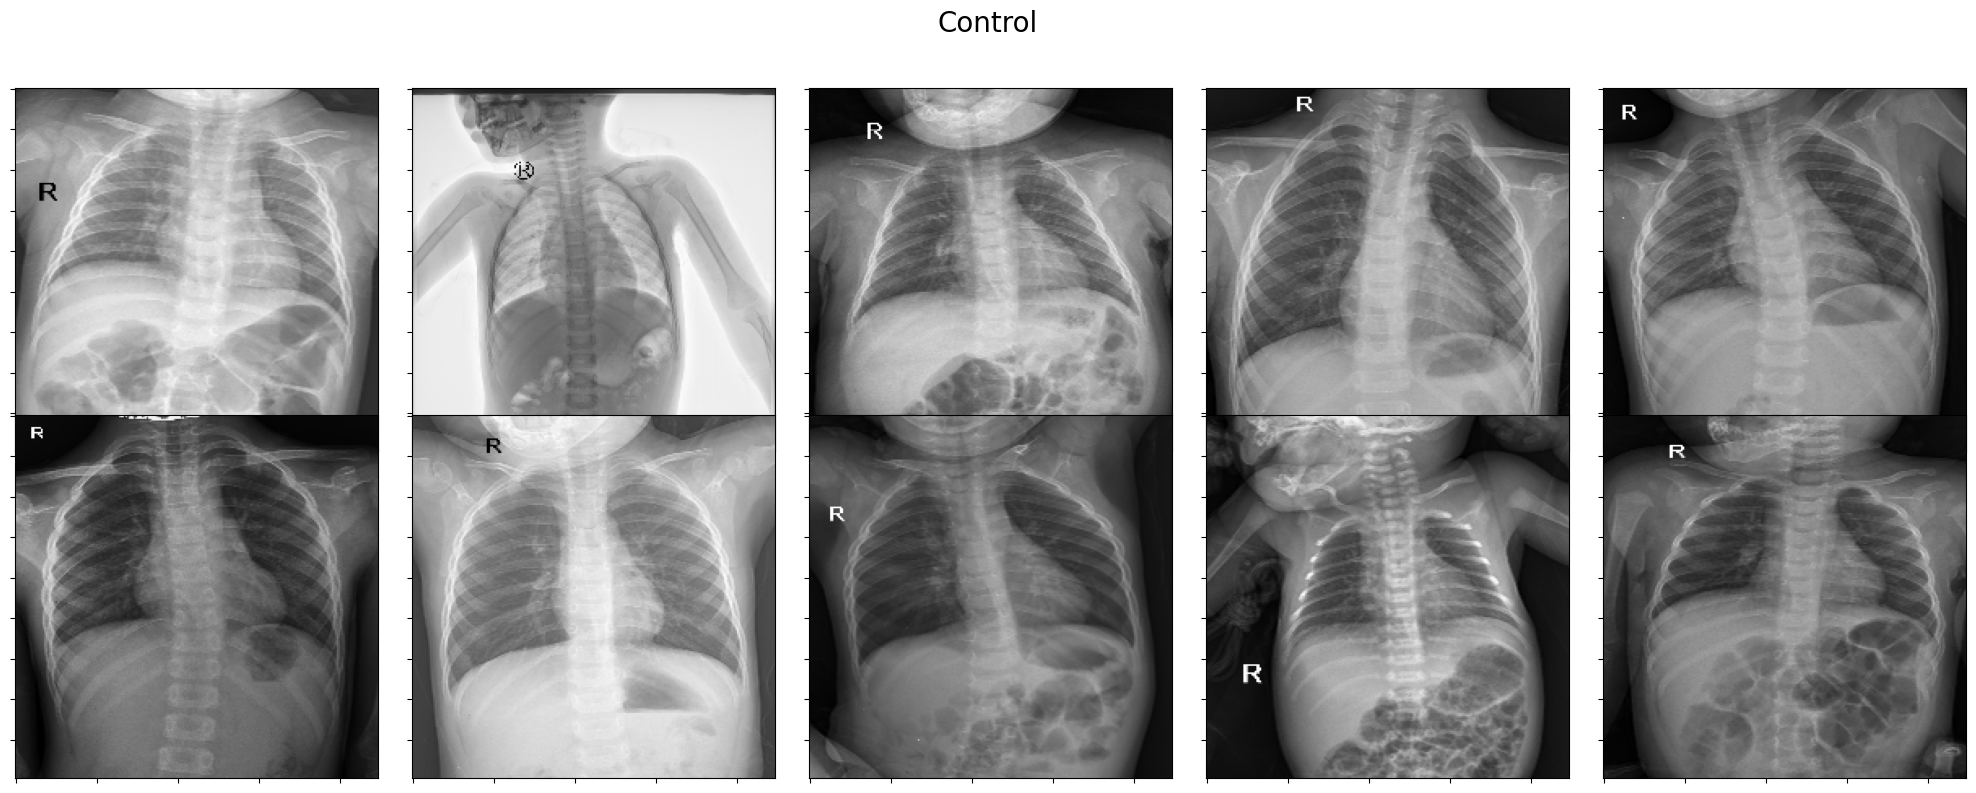

In [61]:
f = plt.figure(figsize=(20,8))
f.subplots_adjust(top=1)
for i in range(10):
    sp = f.add_subplot(2,5,i+1)
    X2 = Control.reshape(-1,size, size)
    X2 = img_to_array(X2[i])
    X2 = 255-X2
    X2 = array_to_img(X2)
    plt.tick_params(labelbottom=False,
                labelleft=False,
                labelright=False,
                labeltop=False)
    plt.imshow(X2)
    plt.gray()
plt.tight_layout(rect=[0,0,1,0.9])
plt.suptitle('Control',fontsize=20)
plt.show()

# Preparation

In [62]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

X_train = x_train.reshape(-1,size, size)
X_test = x_test.reshape(-1,size, size)
X_train = np.repeat(X_train[..., np.newaxis], 3, -1)
X_test = np.repeat(X_test[..., np.newaxis], 3, -1)

Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)

X_train.shape

(5840, 224, 224, 3)

# Efficientnet

In [63]:
import os
import random

os.environ['PYTHONHASHSEED'] = '0'
os.environ['TF_DETERMINISTIC_OPS'] = '1'

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [64]:
input_shape = X_train.shape[1:]
base_input_shape = (224, 224, 3)
num_classes = Y_train.shape[1]
x = inputs = tf.keras.layers.Input(shape=input_shape)

x = tf.keras.layers.Lambda(lambda image: tf.image.resize(image, base_input_shape[0:2]), output_shape=base_input_shape)(x)

base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False, input_shape=base_input_shape, weights="imagenet")
#base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B3(include_top=False, input_shape=base_input_shape, weights="imagenet")
#base_model.trainable = False
#x = base_model(x, training=False)

base_model.trainable = True
x = base_model(x, training=True)

x = tf.keras.layers.Conv2D(32, (3,3), activation='relu')(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.8)(x)
x = tf.keras.layers.Dense(num_classes)(x)
outputs = tf.keras.layers.Activation('softmax')(x)
model = tf.keras.Model(inputs, outputs)

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=["accuracy"]
)

In [65]:
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_4 (Lambda)                    │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b0 (Functional)       │ (None, 7, 7, 1280)          │       5,919,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 5, 5, 32)            │         368,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 32)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 2)                   │              66 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 2)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,288,178 (23.99 MB)

 Trainable params: 6,227,506 (23.76 MB)

 Non-trainable params: 60,672 (237.00 KB)

In [66]:
model_chkpt = ModelCheckpoint('best_mod.keras', save_best_only=True, monitor='val_accuracy')
early_stopping = EarlyStopping(monitor='val_accuracy', restore_best_weights=False, patience=10)

In [67]:
history = model.fit(X_train, Y_train,
          validation_split=0.20,
          epochs=30, batch_size=32, shuffle=True,
          callbacks=[model_chkpt ,early_stopping]
         )

Epoch 1/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 90s 113ms/step - accuracy: 0.5649 - loss: 1.2404 - val_accuracy: 0.7269 - val_loss: 0.6511
Epoch 2/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.6441 - loss: 0.8304 - val_accuracy: 0.7346 - val_loss: 0.5648
Epoch 3/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.6840 - loss: 0.7606 - val_accuracy: 0.7158 - val_loss: 1.0419
Epoch 4/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.6953 - loss: 0.7791 - val_accuracy: 0.7140 - val_loss: 0.5774
Epoch 5/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.6842 - loss: 0.7580 - val_accuracy: 0.7158 - val_loss: 0.5898
Epoch 6/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.6915 - loss: 0.7060 - val_accuracy: 0.7277 - val_loss: 0.5715
Epoch 7/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.7052 - loss: 0.6716 - val_accuracy: 0.7226 - val_loss: 0.5928
Epoch 8/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.6988 - loss: 0.6466 - val_ac

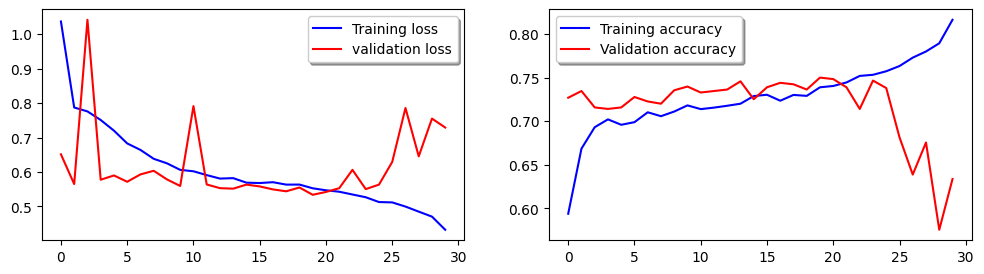

In [68]:
fig, ax = plt.subplots(1,2, figsize=(12, 3))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step


<function matplotlib.pyplot.show(close=None, block=None)>

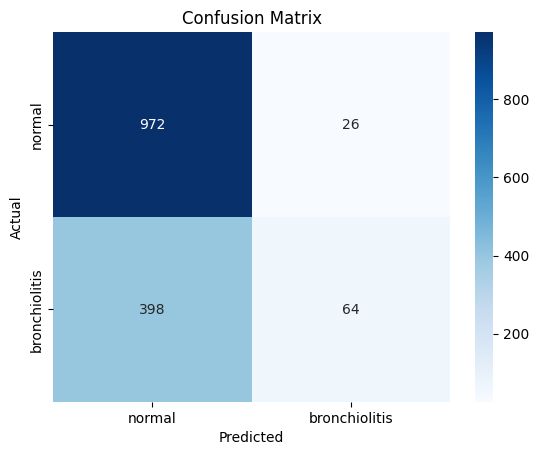

In [69]:
model.load_weights('/content/best_mod.keras')

plt.figure()

ax = plt.subplot()

ax.set_title('Confusion Matrix')
#pred = model.predict_classes(X_test)
pred_probs = model.predict(X_test)
pred = np.argmax(pred_probs, axis=1)

Y_TEST = np.argmax(Y_test, axis =1)
cm = metrics.confusion_matrix(Y_TEST,pred)
classes=['normal', 'bronchiolitis']
sns.heatmap(cm, annot=True,xticklabels=classes, yticklabels=classes,cmap='Blues',fmt=".0f")

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show

In [70]:
print(classification_report(Y_TEST, pred))
print('normal = 0 , case = 1')

              precision    recall  f1-score   support

           0       0.71      0.97      0.82       998
           1       0.71      0.14      0.23       462

    accuracy                           0.71      1460
   macro avg       0.71      0.56      0.53      1460
weighted avg       0.71      0.71      0.63      1460

normal = 0 , case = 1
